# Maldives 2040

Abbreviations:
air-conditioning  (AC) \
Seawater air conditioning (SWAC) \
Reverse Osmosis desalination (RO) \
Deep Seawater Cooling and Desalination (DSCD) 

## 2 METHODOLOGY

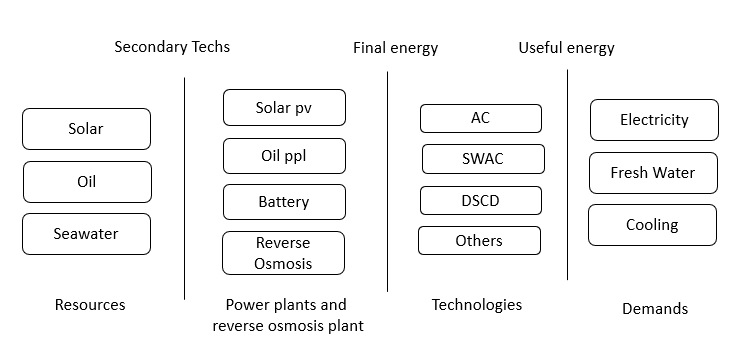

                                       

In [1]:
import itertools
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import ixmp
import message_ix

from message_ix.utils import make_df

In [2]:
mp = ixmp.Platform()

In [3]:
model = "Maldives energy model"
scen = "baseline"

scenario = message_ix.Scenario(mp, model, scen, version='new')

### Time and Spatial Detail

Horizons: 2020, 2025, 2030, 2035, 2040.


In [4]:
history = [2020]
horizon = [2025, 2030, 2035, 2040]
scenario.add_horizon(
    year= history + horizon,
    firstmodelyear=horizon[0]
)

In [5]:
country = 'Maldives'
scenario.add_spatial_sets({'country': country})

In [6]:
scenario.add_set("commodity", ["electricity", 'diesel', 'freshwater', 'cooling'])
scenario.add_set("level", ["secondary", "final", "useful"])
scenario.add_set("technology", ['oil_ppl', 'solar_pv_ppl', 'battery_ppl', 'ro_pl'])
scenario.add_set("mode", "standard")

### 2.1 Growth estimation

<AxesSubplot:title={'center':'Demand'}>

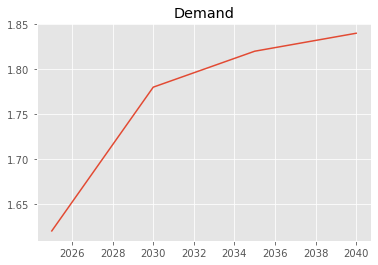

In [8]:
#growth for years 2025, 2030, 2035, 2040
demand = pd.Series([1.62, 1.78, 1.82, 1.84], index=horizon) # data from electricity growth from 2017 up to 2037
demand.plot(title='Demand')

In [9]:
e_plants = [
    "battery_ppl",  #electricity plants
    "oil_ppl", 
    "solar_pv_ppl",
]
w_plants = [ 
    "ro_pl",  #desalination plant
]

secondary_energy_techs = e_plants + w_plants 


others = ['appliances', 'cooking' , 'lighting'] #others electricity demand

useful_techs = ['ac', 'swac', 'dscd'] + others

In [10]:
technologies = secondary_energy_techs + useful_techs
scenario.add_set("technology", technologies)

### 2.2 Demand for electricity, cooling and freshwater

In [14]:
# Adding a new unit to the library
mp.add_unit('MWta')
mp.add_unit('MWa')
mp.add_unit('m^3a')

ac_demand_per_year = (91800/8760)*3 #air conditiong energy demand in 2017
ac_demand = pd.DataFrame({
        'node': country,
        'commodity': 'cooling',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': ac_demand_per_year * demand,
        'unit': 'MWta',
    })
scenario.add_par("demand", ac_demand)

others_demand_per_year = 214200/8760 
others_demand = pd.DataFrame({
        'node': country,
        'commodity': 'electricity',
        'level': 'final',
        'year': horizon,
        'time': 'year',
        'value': others_demand_per_year * demand,
        'unit': 'MWa',
    })
scenario.add_par("demand", others_demand)


freshwater_demand_per_year = 80000*365 #80,000 m^3/d
freshwater_demand = pd.DataFrame({
        'node': country,
        'commodity': 'freshwater',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': freshwater_demand_per_year,
        'unit': 'm^3a', 
    })
scenario.add_par("demand", freshwater_demand)   

INFO:root:unit `MWta` is already defined in the platform instance
INFO:root:unit `MWa` is already defined in the platform instance
INFO:root:unit `m^3a` is already defined in the platform instance


In [19]:
ac_demand

,node,commodity,level,year,time,value,unit
2025,Maldives,cooling,useful,2025,year,50.930137,MWta
2030,Maldives,cooling,useful,2030,year,55.960274,MWta
2035,Maldives,cooling,useful,2035,year,57.217808,MWta
2040,Maldives,cooling,useful,2040,year,57.846575,MWta


In [20]:
others_demand

,node,commodity,level,year,time,value,unit
2025,Maldives,electricity,final,2025,year,39.612329,MWa
2030,Maldives,electricity,final,2030,year,43.524658,MWa
2035,Maldives,electricity,final,2035,year,44.502740,MWa
2040,Maldives,electricity,final,2040,year,44.991781,MWa


### 2.3 Engineering Parameters: inputs and outputs

In [21]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act'] 

In [22]:
base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

In [23]:
#air conditioning
ac_in = make_df(base_input, technology='ac', commodity='electricity',  
                  level='final', value=1.)
scenario.add_par('input', ac_in)
ac_out = make_df(base_output, technology='ac', commodity='cooling', 
                   level='useful', value=3., unit='MWta')
scenario.add_par('output', ac_out)

In [24]:
#Seawater air conditioning (swac)
swac_in = make_df(base_input, technology='swac', commodity='electricity',  
                  level='final', value=1.)
scenario.add_par('input', swac_in)
swac_out = make_df(base_output, technology='swac', commodity='cooling', 
                   level='useful', value=20., unit='MWta')
scenario.add_par('output', swac_out)

In [25]:
#secondary to useful w_tec

#reverse osmosis - water demand (row)
ro_in = make_df(base_input, technology='ro_pl', commodity='electricity',  
                  level='final', value=1.)
scenario.add_par('input', ro_in)
ro_out = make_df(base_output, technology='ro_pl', commodity='freshwater', 
                   level='useful', value=3100000, unit="m^3a")
scenario.add_par('output', ro_out)

In [26]:
#dscd
#deep seawater cooling and desalination - cooling demand (dscdc)

dscdc_in = make_df(base_input, technology='dscd', commodity='electricity',  
                  level='final', value=1.)
scenario.add_par('input', dscdc_in)
dscdc_out = make_df(base_output, technology='dscd', commodity='cooling', 
                   level='useful', value=40, unit="MWta")
scenario.add_par('output', dscdc_out)
dscdw_out = make_df(base_output, technology='dscd', commodity='freshwater', 
                   level='useful', value=3100000, unit="m^3a")
scenario.add_par('output', dscdw_out)

In [27]:
#secondary to useful e_tecs

oil_out = make_df(base_output, technology='oil_ppl', commodity='electricity', 
                   level='final', value=1., unit="MWa")
scenario.add_par('output', oil_out)

solar_pv_out = make_df(base_output, technology='solar_pv_ppl', commodity='electricity', 
                   level='final', value=1., unit="MWa")
scenario.add_par('output', solar_pv_out)

battery_out = make_df(base_output, technology='battery_ppl', commodity='electricity', 
                   level='final', value=1., unit="MWa")
scenario.add_par('output', battery_out)

### 2.4 Operational Constraints and Parameters

In [28]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

capacity_factor = {
    'oil_ppl': 0.75,
    'battery_ppl': 0.3, 
    'solar_pv_ppl': 0.3,
    'ac': 0.3,
    'ro_pl': 0.8,
    'swac': 0.8, 
    'dscd': 0.8,  
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scenario.add_par('capacity_factor', df)

In [29]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': horizon,
    'unit': 'y',
}

lifetimes = {
    'oil_ppl': 30,
    'battery_ppl': 5,
    'solar_pv_ppl': 20,
    'ac': 15,
    'ro_pl': 20,
    'swac': 20, 
    'dscd': 20, 
}

for tec, val in lifetimes.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scenario.add_par('technical_lifetime', df)

### 2.5 Technological Diffusion and Contraction

In [30]:
historic_e_generation = others_demand_per_year + ac_demand_per_year/3 
historic_c_generation = ac_demand_per_year 
historic_w_generation = freshwater_demand_per_year

In [49]:
historic_c_generation

10.479452054794521

In [32]:
base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'MWa',
}

old_activity = {
    'solar_pv_ppl': 0.05*historic_e_generation,
    'oil_ppl': 0.95*historic_e_generation,
    'ac':  1.* historic_c_generation,
    'ro_pl': 1.* historic_w_generation,
    'swac': 0., 
    'dscd': 0.,
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scenario.add_par('historical_activity', df)

In [33]:
base_initial = {
    'node_loc': country,
    'year_act': horizon,
    'time': 'year',
    'unit': '%',
}


for tec, val in old_activity.items():
    df = make_df(base_initial, technology=tec, value=val) #multipliquei pela demand
    scenario.add_par('initial_activity_up', df) 

In [34]:
scenario.add_par("interestrate", horizon, value=0.05, unit='-')

### 2.6Technoeconomic Parameters

In [35]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': horizon, 
    'unit': 'USD/kW',
}

costs = {
    'oil_ppl': 950, #value from Austria baseline model 
    'battery_ppl': 800, #value from MESSAGE-BRAZIL baseline 
    'solar_pv_ppl': 677, #value from IEA for India in 2019
    'ac': 880, #average price for commercial buildings in USA
    'ro_pl': 950, # in this case it is USD/km³ 
    'swac': 768, # USD/kW
    'dscd': (950 + 768)*0.7, 
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scenario.add_par('inv_cost', df)

In [36]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}


costs = {
    'oil_ppl': 25, #value from Austria baseline model 
    'battery_ppl': 32, #value from MESSAGE-BRAZIL baseline
    'solar_pv_ppl': 5, #value from MESSAGE-BRAZIL baseline
    'ac': 30, 
    'ro_pl': 280,
    'swac': 195., 
    'dscd': (280+195)*0.7, 
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scenario.add_par('fix_cost', df)

In [37]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

costs = {
    'oil_ppl': 77.8, #value from Austria baseline model 
    'battery_ppl': 0, #value from MESSAGE-BRAZIL baseline
    'solar_pv_ppl': 0, #value from MESSAGE-BRAZIL baseline
    'ro_pl': 0,
    'swac': 0., 
    'dscd': 0, 
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val) 
    scenario.add_par('var_cost', df)

### Commit the datastructure and solve the model

In [38]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scenario.version))
scenario.commit(comment='basic model of Maldives')
log.info('version number prior committing to the database: {}'.format(scenario.version))

INFO:message_ix:version number prior to commit: 0
INFO:message_ix:version number prior committing to the database: 32


In [39]:
scenario.set_as_default()

In [40]:
scenario.solve()

In [41]:
scenario.var('OBJ')['lvl']

236489.609375

## 3. Plotting Results

In [42]:
import pyam
from ixmp.reporting import configure
from message_ix.reporting import Reporter
import os
import matplotlib.pyplot as plt
configure(units={'replace': {'-': 'MWa'}})

<IPython.core.display.Javascript object>

In [43]:
rep = Reporter.from_scenario(scenario)

In [44]:
# plotting years
plotyrs = [x for x in set(scenario.set('year')) if x >= scenario.firstmodelyear]

In [45]:
rep.set_filters(c = 'cooling')
cool = rep.full_key('out')
cool = cool.drop('yv','m','nd','hd','h')
cool_gen = rep.get(cool)
cool_gen

nl        t     ya    l       c      
Maldives  ac    2025  useful  cooling    50.930137
                2030  useful  cooling    55.960274
                2035  useful  cooling    57.217808
                2040  useful  cooling    57.846575
          dscd  2025  useful  cooling     0.000000
                2030  useful  cooling     0.000000
                2035  useful  cooling     0.000000
                2040  useful  cooling     0.000000
          swac  2025  useful  cooling     0.000000
                2030  useful  cooling     0.000000
                2035  useful  cooling     0.000000
                2040  useful  cooling     0.000000
dtype: float64

In [46]:
rep.set_filters(c = 'electricity')
elec = rep.full_key('out')
elec = elec.drop('yv','m','nd','hd','h')
elec_gen = rep.get(elec)
elec_gen

nl        t             ya    l      c          
Maldives  battery_ppl   2025  final  electricity     0.000000
                        2030  final  electricity     0.000000
                        2035  final  electricity     0.000000
                        2040  final  electricity     0.000000
          oil_ppl       2025  final  electricity    55.528944
                        2030  final  electricity    55.528944
                        2035  final  electricity    55.528944
                        2040  final  electricity    55.528944
          solar_pv_ppl  2025  final  electricity    10.479452
                        2030  final  electricity    16.068493
                        2035  final  electricity    17.465753
                        2040  final  electricity    18.164384
dtype: float64

In [47]:
rep.set_filters(c = 'freshwater')
wat = rep.full_key('out')
wat = elec.drop('yv','m','nd','hd','h')
wat_gen = rep.get(wat)
wat_gen

nl        t      ya    l       c         
Maldives  dscd   2025  useful  freshwater           0.0
                 2030  useful  freshwater           0.0
                 2035  useful  freshwater           0.0
                 2040  useful  freshwater           0.0
          ro_pl  2025  useful  freshwater    29200000.0
                 2030  useful  freshwater    29200000.0
                 2035  useful  freshwater    29200000.0
                 2040  useful  freshwater    29200000.0
dtype: float64

In [50]:
inv = rep.full_key('inv')
inv_cost = rep.get(inv)
    
def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Invesment Cost|' + df['t']
    return df.drop(['t'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=inv,
        year_time_dim='yv',
        collapse=collapse_callback)
    
new_key = new_key[0]      # Unwrap the single item in the list  
df = rep.get(new_key)

In [51]:
inv_cost 

nl        t             yv  
Maldives  ac            2025     9959.671233
                        2030      983.671233
                        2035      245.917808
                        2040    10082.630137
          battery_ppl   2025        0.000000
                        2030        0.000000
                        2035        0.000000
                        2040        0.000000
          dscd          2025        0.000000
                        2030        0.000000
                        2035        0.000000
                        2040        0.000000
          oil_ppl       2025    14067.332450
                        2030        0.000000
                        2035        0.000000
                        2040        0.000000
          ro_pl         2025     2237.096774
                        2030        0.000000
                        2035        0.000000
                        2040        0.000000
          solar_pv_ppl  2025     4729.726027
                        20

In [52]:
# Demands
dmd = rep.full_key('demand')
dmd = dmd.drop('h', 'l')
rep.get(dmd)   
    
def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Demand|' + df['c']
    return df.drop(['c'], axis=1)
    
new_key = rep.convert_pyam(
        quantities= dmd,
        year_time_dim='y',
        collapse=collapse_callback)
    
new_key = new_key[0]  # Unwrap the single item in the list
    
df_dmd = rep.get(new_key)

# if filtering for plot yrs is required 
df_dmd = df_dmd.filter(year= plotyrs)

In [53]:
dmd

<demand:n-c-y>

In [54]:
# For electricity generation, I filter out electr commodity and report output to see only electricity output here 
# This filter can be changed for any other commdodity too 
rep.set_filters(c = 'electricity')
elec = rep.full_key('out')
elec = elec.drop('yv','m','nd','hd','h')
elec_gen = rep.get(elec)
elec_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=elec,
        year_time_dim='ya',
        collapse=collapse_callback)
    
new_key = new_key[0]  # Unwrap the single item in the list
    
df_elec = rep.get(new_key)
df_elec.data.unit = 'MWa'
df_elec.to_csv('electricity.csv')

In [55]:
elec_gen = pd.read_csv("electricity.csv")
elec_gen.columns 

Index(['Model', 'Scenario', 'Region', 'Variable', 'Unit', 'C', '2025', '2030',
       '2035', '2040'],
      dtype='object')

In [56]:
# Loading data from csv into a pyam format
elec_gen = pyam.IamDataFrame(data='electricity.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
elec_gen.data

INFO:pyam.core:Reading file electricity.csv


,model,scenario,region,variable,unit,year,c,value
0,Maldives energy model,baseline,Maldives,Electricity Generation|final|battery_ppl,MWa,2025,electricity,0.000000
1,Maldives energy model,baseline,Maldives,Electricity Generation|final|battery_ppl,MWa,2030,electricity,0.000000
2,Maldives energy model,baseline,Maldives,Electricity Generation|final|battery_ppl,MWa,2035,electricity,0.000000
3,Maldives energy model,baseline,Maldives,Electricity Generation|final|battery_ppl,MWa,2040,electricity,0.000000
4,Maldives energy model,baseline,Maldives,Electricity Generation|final|oil_ppl,MWa,2025,electricity,55.528944
5,Maldives energy model,baseline,Maldives,Electricity Generation|final|oil_ppl,MWa,2030,electricity,55.528944
6,Maldives energy model,baseline,Maldives,Electricity Generation|final|oil_ppl,MWa,2035,electricity,55.528944
7,Maldives energy model,baseline,Maldives,Electricity Generation|final|oil_ppl,MWa,2040,electricity,55.528944
8,Maldives energy model,baseline,Maldives,Electricity Generation|final|solar_pv_ppl,MWa,2025,electricity,10.479452
9,Maldives energy model,baseline,Maldives,Electricity Generation|final|solar_pv_ppl,MWa,2030,electricity,16.068493


<AxesSubplot:title={'center':'model: Maldives energy model scenario: baseline region: Maldives'}, xlabel='Year', ylabel='MWa'>

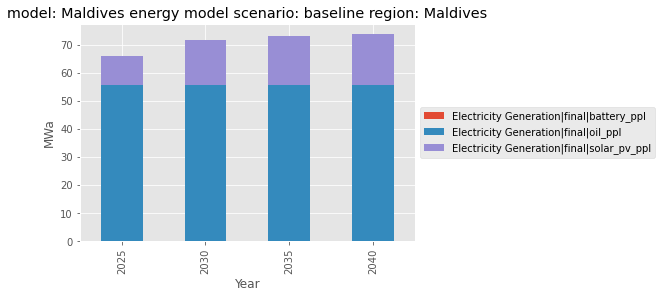

In [57]:
elec = elec_gen.filter(region=['Maldives'], variable='Electricity Generation|final|*', year=plotyrs)
elec.plot.bar(stacked=True)

In [58]:
rep.set_filters(c = 'cooling')
cool = rep.full_key('out')
cool = cool.drop('yv','m','nd','hd','h')
cool_gen = rep.get(cool)
cool_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=cool,
        year_time_dim='ya',
        collapse=collapse_callback)
    
new_key = new_key[0]  # Unwrap the single item in the list
    
df_cool = rep.get(new_key)
df_cool.data.unit = 'MWa'
df_cool.to_csv('cooling.csv')

In [59]:
elec_gen = pd.read_csv("cooling.csv")
elec_gen.columns 

Index(['Model', 'Scenario', 'Region', 'Variable', 'Unit', 'C', '2025', '2030',
       '2035', '2040'],
      dtype='object')

In [60]:
# Loading data from csv into a pyam format
cool_gen = pyam.IamDataFrame(data='cooling.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
cool_gen.data

INFO:pyam.core:Reading file cooling.csv


,model,scenario,region,variable,unit,year,c,value
0,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ac,MWta,2025,cooling,50.930137
1,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ac,MWta,2030,cooling,55.960274
2,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ac,MWta,2035,cooling,57.217808
3,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ac,MWta,2040,cooling,57.846575
4,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,MWta,2025,cooling,0.000000
5,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,MWta,2030,cooling,0.000000
6,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,MWta,2035,cooling,0.000000
7,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,MWta,2040,cooling,0.000000
8,Maldives energy model,baseline,Maldives,Electricity Generation|useful|swac,MWta,2025,cooling,0.000000
9,Maldives energy model,baseline,Maldives,Electricity Generation|useful|swac,MWta,2030,cooling,0.000000


<AxesSubplot:title={'center':'model: Maldives energy model scenario: baseline region: Maldives'}, xlabel='Year', ylabel='MWta'>

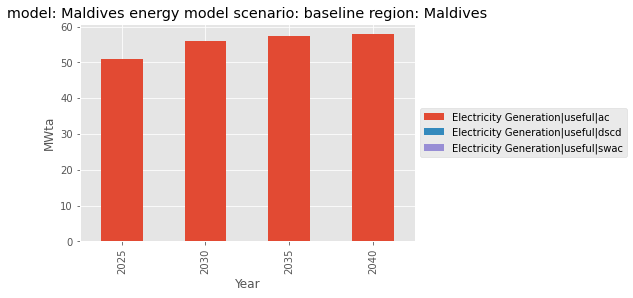

In [61]:
cool = cool_gen.filter(region=['Maldives'], variable='Electricity Generation|useful|*', year=plotyrs)
cool.plot.bar(stacked=True)

In [62]:
rep.set_filters(c = 'freshwater')
wat = rep.full_key('out')
wat = wat.drop('yv','m','nd','hd','h')
wat_gen = rep.get(wat)
wat_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=wat,
        year_time_dim='ya',
        collapse=collapse_callback)
    
new_key = new_key[0]  # Unwrap the single item in the list
    
df_wat = rep.get(new_key)
df_wat.data.unit = 'm^3'
df_wat.to_csv('freshwater.csv')

In [63]:
elec_gen = pd.read_csv("freshwater.csv")

In [64]:
# Loading data from csv into a pyam format
wat_gen = pyam.IamDataFrame(data='freshwater.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
wat_gen.data

INFO:pyam.core:Reading file freshwater.csv


,model,scenario,region,variable,unit,year,c,value
0,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2025,freshwater,0.0
1,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2030,freshwater,0.0
2,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2035,freshwater,0.0
3,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2040,freshwater,0.0
4,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2025,freshwater,29200000.0
5,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2030,freshwater,29200000.0
6,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2035,freshwater,29200000.0
7,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2040,freshwater,29200000.0


<AxesSubplot:title={'center':'model: Maldives energy model scenario: baseline region: Maldives'}, xlabel='Year', ylabel='a * m ** 3'>

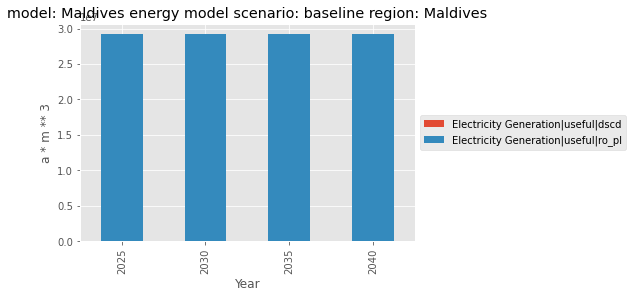

In [65]:
wat = wat_gen.filter(region=['Maldives'], variable='Electricity Generation|useful|*', year=plotyrs)
wat.plot.bar(stacked=True)

In [66]:
mp.close_db()